In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
# Read JSON file with the data and show it as a dataframe

base_temperatures = pd.read_json('input_data/temperature_modis.json')
base_temperatures.sort_index(inplace=True)
temperatures = base_temperatures.copy()
base_temperatures.head()

,lst_day,lst_night
2000-02-01,282.345703,274.942841
2000-03-01,279.169983,271.005707
2000-04-01,297.531433,281.921417
2000-05-01,301.162842,284.088531
2000-06-01,303.914276,287.919983


In [3]:
# Add month and year column and prepare data visualization

temperatures['month'] = temperatures.index.month
temperatures['year'] = temperatures.index.year
temperatures.head()

,lst_day,lst_night,month,year
2000-02-01,282.345703,274.942841,2,2000
2000-03-01,279.169983,271.005707,3,2000
2000-04-01,297.531433,281.921417,4,2000
2000-05-01,301.162842,284.088531,5,2000
2000-06-01,303.914276,287.919983,6,2000


In [4]:
# Plot temperature values over time

def celsius(k):
    c = k - 273.15
    return c

t_day = temperatures.pivot("month", "year", "lst_day")
t_day = t_day.apply(lambda x: celsius(x))
t_night = temperatures.pivot("month", "year", "lst_night")
t_night = t_night.apply(lambda x: celsius(x))

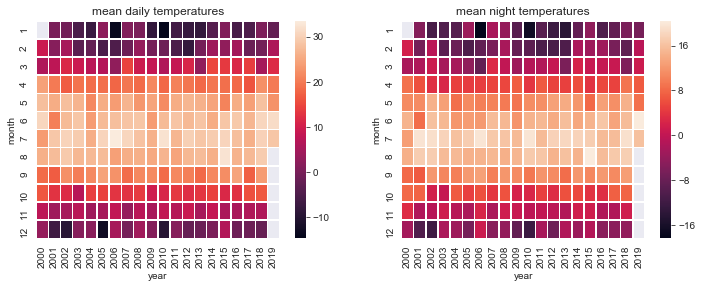

In [5]:
f1, (ax_day, ax_night) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.heatmap(t_day, linewidths=.5, ax=ax_day)
ax_day.set_title('mean daily temperatures')
sns.heatmap(t_night, linewidths=.5, ax=ax_night)
ax_night.set_title('mean night temperatures')
plt.show()

In [6]:
# Plot temperatures against the mean temperature for a given month over the years

t_day_means = t_day[[2000, 2001, 2002, 2003, 2004]].mean(axis=1, skipna=True)
t_night_means = t_night[[2000, 2001, 2002, 2003, 2004]].mean(axis=1, skipna=True)

In [7]:
t_day_normalized = t_day.subtract(t_day_means, axis=0)
t_night_normalized = t_night.subtract(t_night_means, axis=0)

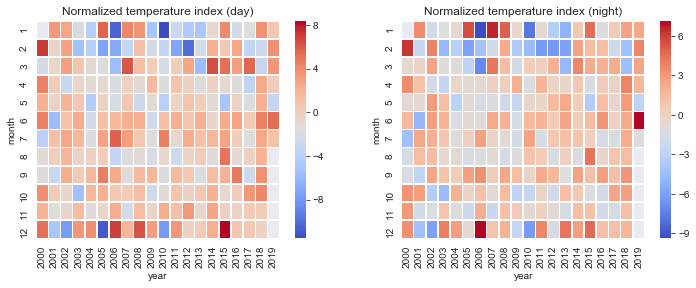

In [8]:
f1, (ax_day, ax_night) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.heatmap(t_day_normalized, linewidths=.5, ax=ax_day, cmap="coolwarm")
ax_day.set_title('Normalized temperature index (day)')
sns.heatmap(t_night_normalized, linewidths=.5, ax=ax_night, cmap="coolwarm")
ax_night.set_title('Normalized temperature index (night)')
plt.show()

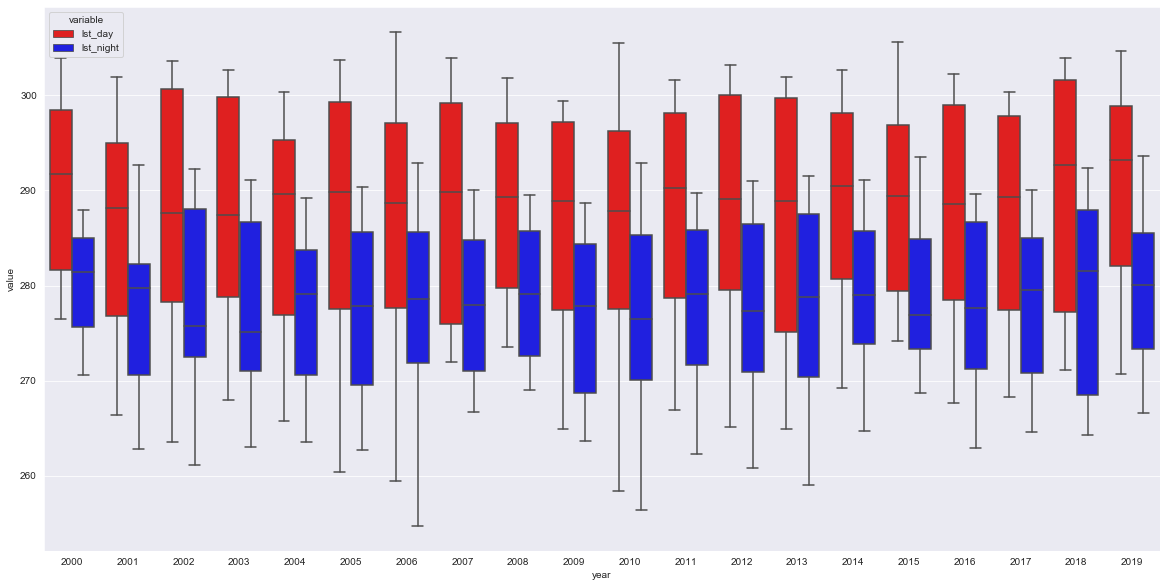

In [9]:
# Show boxplot of the temperatures over a measured period of time...

temp_series = temperatures.melt(id_vars=['year'], value_vars=['lst_day', 'lst_night'])
plt.figure(figsize=(20, 10))
ax_boxplot = sns.boxplot(data = temp_series,
                        x = 'year',
                        y = 'value',
                        hue = 'variable',
                        palette = ['red', 'blue'])
plt.show()

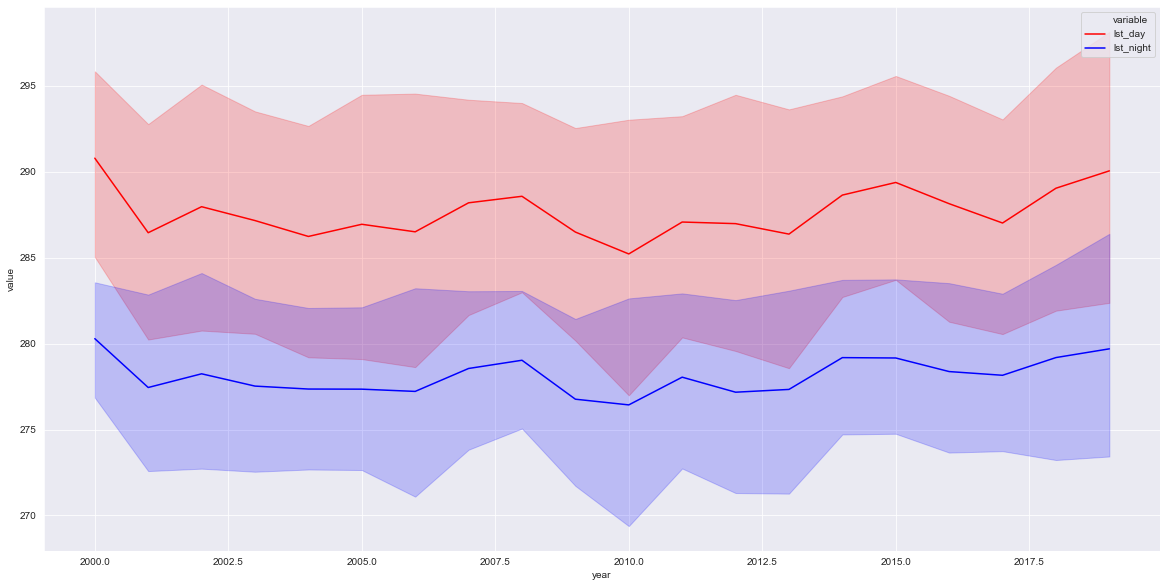

In [10]:
# ...and the lineplot

plt.figure(figsize=(20, 10))
ax_lineplot = sns.lineplot(data = temp_series,
                           x = 'year',
                           y = 'value',
                           hue = 'variable',
                           palette = ['red', 'blue'])
plt.show()

In [11]:
# Calculate trend in the data

def trend(time_series, order=1):
    coeffs = np.polyfit(time_series.index.values, list(time_series), order)
    slope = coeffs[0]
    return float(slope)

series_day = temp_series[temp_series.variable == 'lst_day'].groupby(by='year')['value'].mean()
series_night = temp_series[temp_series.variable == 'lst_night'].groupby(by='year')['value'].mean()

day_trend = trend(series_day)
night_trend = trend(series_night)

print(day_trend, night_trend)

0.04932955466952601 0.0414162916942112


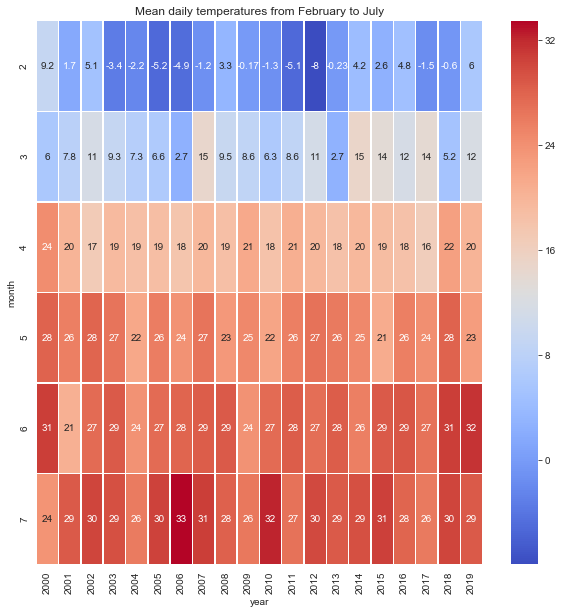

In [12]:
# Missing values problem

# Solution one: use only months with known values, e.g. from February to July or from one season

t_day_dropped = t_day.drop([1, 8, 9, 10, 11, 12])
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(t_day_dropped, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")
ax.set_title('Mean daily temperatures from February to July')
plt.show()

In [13]:
series_day_dropped = t_day_dropped.mean()
t_night_dropped = t_night.drop([1, 8, 9, 10, 11, 12])
series_night_dropped = t_night_dropped.mean()
print(trend(series_day_dropped), trend(series_night_dropped))

0.0465302660949293 0.05572574395584036


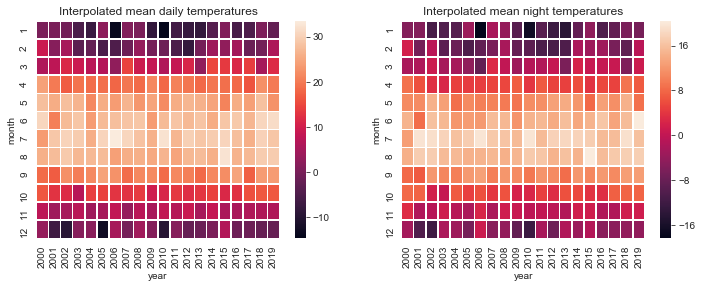

In [14]:
# Solution two: missing values as a linear interpolation of the known values

interpolated_day = t_day.interpolate(axis=1, limit_direction='both')
interpolated_night = t_night.interpolate(axis=1, limit_direction='both')
f1, (ax_day, ax_night) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.heatmap(interpolated_day, linewidths=.5, ax=ax_day)
ax_day.set_title('Interpolated mean daily temperatures')
sns.heatmap(interpolated_night, linewidths=.5, ax=ax_night)
ax_night.set_title('Interpolated mean night temperatures')
plt.show()

In [15]:
series_day_interpolated = interpolated_day.mean()
series_night_interpolated = interpolated_night.mean()
print(trend(series_day_interpolated), trend(series_night_interpolated))

0.05752971142456157 0.05919195667544478


In [16]:
# Summary statistics

print('Trend of the base dataset:\nDay: {},\nNight: {}'.format(day_trend, night_trend))
print('\n')
print('Trend of the months between February and July:\nDay: {},\nNight: {}'.format(
    trend(series_day_dropped),
    trend(series_night_dropped))
     )
print('\n')
print('Trend of the interpolated dataset:\nDay: {},\nNight: {}'.format(
    trend(series_day_interpolated),
    trend(series_night_interpolated))
     )

Trend of the base dataset:
Day: 0.04932955466952601,
Night: 0.0414162916942112


Trend of the months between February and July:
Day: 0.0465302660949293,
Night: 0.05572574395584036


Trend of the interpolated dataset:
Day: 0.05752971142456157,
Night: 0.05919195667544478


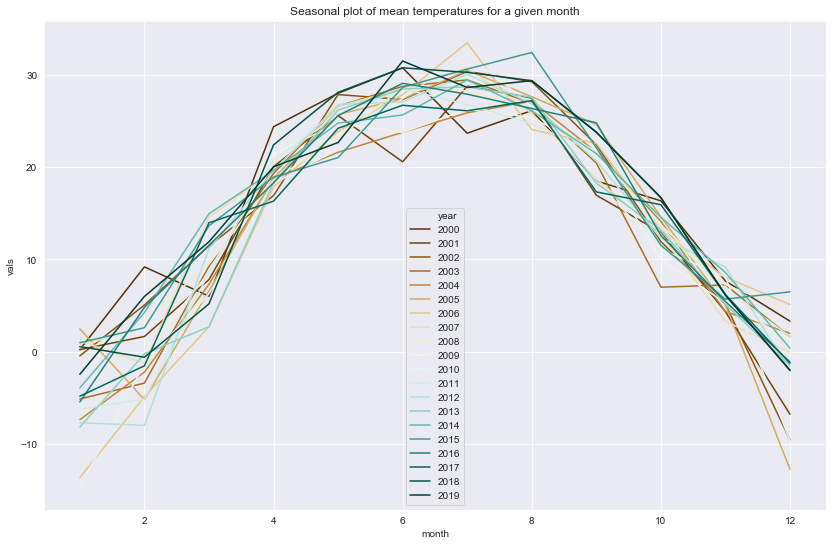

In [17]:
# Last but not least: seasonal plot

iday = interpolated_day.reset_index()
iday_melted = iday.melt(id_vars='month', var_name='year', value_name='vals')
iday_melted['year'] = pd.to_numeric(iday_melted['year'])

f, ax = plt.subplots(figsize=(14, 9))
sns.lineplot(x='month', y='vals', hue='year', data=iday_melted,
             palette='BrBG', legend='full')
ax.set_title('Seasonal plot of mean temperatures for a given month')
plt.show()